In [71]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress
import pprint
import json
from time import sleep
from datetime import date
import zipfile
import os

# Incorporated citipy to determine city based on latitude and longitude
# pip install citipy
from citipy import citipy

# Output File location
output_folder = "output_data"

In [72]:
# Open the zip file:
csvpath = os.path.join("..", "source_data", "detail_listings.zip")
zf = zipfile.ZipFile(csvpath);

# zf = zipfile.ZipFile('../source_data/detail_listings.zip') 
df = pd.read_csv(zf.open('detail_listings.csv'), low_memory=False)

rows_in_df = len(df)
print(f'Data set has {rows_in_df} rows')

# Drop unneeded columns:
df = df.drop(columns = [
    "listing_url", 
    "thumbnail_url", 
    "picture_url", 
    "medium_url", 
    "xl_picture_url", 
    "host_url", 
    "host_thumbnail_url", 
    "host_picture_url", 
    "scrape_id",
    "host_listings_count", # There is a host_total_listings_count that is a dupe
    "host_acceptance_rate", # NaN
    "calendar_last_scraped",
    "bed_type",
    "last_scraped",
    "calendar_updated",
    "has_availability",
    "availability_30", 
    "availability_60", 
    "availability_90", 
    "availability_365", 
    "license"
])

df.head(1)

Data set has 23745 rows


,id,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,5065,MAUKA BB,"Perfect for your vacation, Staycation or just ...",Mauka B & B is 400 square feet studio with a p...,"Perfect for your vacation, Staycation or just ...",none,Neighbors here are friendly but are not really...,Located near by is Kalopa State Park with 100 ...,There is a bus stop located in Honoka'a town ...,A BBQ grill is available,...,f,f,moderate,f,f,2,2,0,0,0.45


In [3]:
# Group the columns to make analysis easier later
        
print('')
print('----------------------')
print('Property-specific columns:')
print('----------------------')
# These are wildcard search terms:
cols = ["experiences_offered", "street", "city", "state", "zipcode", "market", "country", "property"
    , "location", "accomodate", "room", "guest", "is_business_travel_ready", "instant_bookable", "cancel"]
for col in df.columns: 
    if col in cols:
        print(col) 
        
print('')
print('----------------------')
print('All columns:')
print('----------------------')
for col in df.columns: 
    print(col) 


----------------------
Property-specific columns:
----------------------
experiences_offered
street
city
state
zipcode
market
country
instant_bookable
is_business_travel_ready

----------------------
All columns:
----------------------
id
name
summary
space
description
experiences_offered
neighborhood_overview
notes
transit
access
interaction
house_rules
host_id
host_name
host_since
host_location
host_about
host_response_time
host_response_rate
host_is_superhost
host_neighbourhood
host_total_listings_count
host_verifications
host_has_profile_pic
host_identity_verified
street
neighbourhood
neighbourhood_cleansed
neighbourhood_group_cleansed
city
state
zipcode
market
smart_location
country_code
country
latitude
longitude
is_location_exact
property_type
room_type
accommodates
bathrooms
bedrooms
beds
amenities
square_feet
price
weekly_price
monthly_price
security_deposit
cleaning_fee
guests_included
extra_people
minimum_nights
maximum_nights
minimum_minimum_nights
maximum_minimum_nights
m

In [73]:
# Create a dataframe w 1 row for each column in the source:
data_dict = pd.DataFrame(columns = [
    "ColumNumber"
    , "Column"
    , "Group"
    , "Subgroup"
    , "Notes"
])

for column in df:
    data_dict = data_dict.append({
            "Column": column
            , "Group": ""
            , "Subgroup": ""
            , "Notes": ""
        }
        , ignore_index=True
    )

# Make the index the column #
data_dict['ColumNumber'] = data_dict.index
        
# For each column, add context:
for index, row in data_dict.iterrows():
    val = str(row["Column"])
    
    if val == "id":
        data_dict.loc[index, "Notes"] = "Primary Key"
    
    if val.find("host") > -1: # val.startswith("host_"):
        data_dict.loc[index, "Group"] = "Host-related"
    
    if val.find("review") > -1:
        data_dict.loc[index, "Group"] = "Review-related"
        
    if (val.find("rule") > -1) | (val.find("require") > -1):
        data_dict.loc[index, "Group"] = "Requirements-related"
        
    if (val.find("neighbo") > -1):
        data_dict.loc[index, "Group"] = "Neighborhood-related"
        
    if (val.find("nights") > -1):
        data_dict.loc[index, "Group"] = "Booking-related"
        
    # Property specific:
    cols = [
        "property", "room", "guest", "is_business_travel_ready", "instant_bookable", "cancel"
        , "space", "name", "summary", "description", "notes", "transit", "access", "interaction"
        , "property_type", "room_type", "amenities"
    ]
    if any(word in val for word in cols):
        data_dict.loc[index, "Group"] = "Property-related"
        
    # Property - "Location" specific:
    cols = [
        "location", "street", "city", "state", "zipcode", "market", "country"
        , "latitude", "longitude", "is_location_exact"
    ]
    if any(word in val for word in cols):
        data_dict.loc[index, "Group"] = "Property-related"
        data_dict.loc[index, "Subgroup"] = "Location"
        
    # Property - "Interior" specific:
    cols = [
        "bathrooms", "bedrooms", "beds", "square_feet"
    ]
    if any(word in val for word in cols):
        data_dict.loc[index, "Group"] = "Property-related"
        data_dict.loc[index, "Subgroup"] = "Interior"
        
    # Property - "Pricing" specific:
    # Things about price, or that we might associate w price
    cols = [
        "price", "weekly_price", "monthly_price"        
        , "security_deposit", "cleaning_fee"
        , "accomodates", "guests_included", "extra_people"
        , "experiences_offered"
    ]
    if any(word in val for word in cols):
        data_dict.loc[index, "Group"] = "Property-related"
        data_dict.loc[index, "Subgroup"] = "Pricing"
        
    # Had to hard code this one for some reason:
    if val == "accommodates":
        data_dict.loc[index, "Group"] = "Property-related"
        data_dict.loc[index, "Subgroup"] = "Pricing"
        
print(data_dict.groupby(["Group", "Subgroup"])["Column"].count())
print('')
print('Columns without a group:')
data_dict[data_dict["Group"] == ""]

# neighbourhood_group_cleansed == island name

Group                 Subgroup
                                   1
Booking-related                    8
Host-related                      12
Neighborhood-related               5
Property-related                  20
                      Interior     4
                      Location    13
                      Pricing      9
Requirements-related               2
Review-related                    11
Name: Column, dtype: int64

Columns without a group:


,ColumNumber,Column,Group,Subgroup,Notes
0,0,id,,,Primary Key


In [74]:
# CLEANUP 

# Drop rows with number_of_reviews = 0
# Get names of indexes for which column number_of_reviews has value 0
# Drop by index:
indexNames = df[df['number_of_reviews'] == 0 ].index
df.drop(indexNames , inplace=True)

# Drop rows with number_of_reviews = NaN
df.dropna(axis=0, subset=('number_of_reviews', ))

# Drop rows with NaN review data
df.dropna(axis=0, subset=(
    'review_scores_rating', 
    'review_scores_accuracy', 
    'review_scores_cleanliness', 
    'review_scores_checkin', 
    'review_scores_communication', 
    'review_scores_location', 
    'review_scores_value'
))

print(f'Remaining rows after cleanup: {len(df)}')

Remaining rows after cleanup: 18291


In [76]:
# Source data has $ and commas 
# Strip the $ out of the pricing-based columns
data_dict[(data_dict["Group"] == "Property-related") & (data_dict["Subgroup"] == "Pricing")]

,ColumNumber,Column,Group,Subgroup,Notes
5,5,experiences_offered,Property-related,Pricing,
41,41,accommodates,Property-related,Pricing,
47,47,price,Property-related,Pricing,
48,48,weekly_price,Property-related,Pricing,
49,49,monthly_price,Property-related,Pricing,
50,50,security_deposit,Property-related,Pricing,
51,51,cleaning_fee,Property-related,Pricing,
52,52,guests_included,Property-related,Pricing,
53,53,extra_people,Property-related,Pricing,


In [77]:
# Strip the $ out of the pricing-based columns
data_dict[(data_dict["Group"] == "Property-related") & (data_dict["Subgroup"] == "Pricing")]

if df["price"].dtype != "float64":
    df["price"] = df["price"].str.replace("$", "")
    df["price"] = df["price"].str.replace(",", "")
    df["price"] = df["price"].astype("float64")

if df["weekly_price"].dtype != "float64":
    df["weekly_price"] = df["weekly_price"].str.replace("$", "")
    df["weekly_price"] = df["weekly_price"].str.replace(",", "")
    df["weekly_price"] = df["weekly_price"].astype("float64")

if df["monthly_price"].dtype != "float64":
    df["monthly_price"] = df["monthly_price"].str.replace("$", "")
    df["monthly_price"] = df["monthly_price"].str.replace(",", "")
    df["monthly_price"] = df["monthly_price"].astype("float64")
    
if df["security_deposit"].dtype != "float64":
    df["security_deposit"] = df["security_deposit"].str.replace("$", "")
    df["security_deposit"] = df["security_deposit"].str.replace(",", "")
    df["security_deposit"] = df["security_deposit"].astype("float64")
    
if df["cleaning_fee"].dtype != "float64":
    df["cleaning_fee"] = df["cleaning_fee"].str.replace("$", "")
    df["cleaning_fee"] = df["cleaning_fee"].str.replace(",", "")
    df["cleaning_fee"] = df["cleaning_fee"].astype("float64")   

if df["extra_people"].dtype != "float64":
    df["extra_people"] = df["extra_people"].str.replace("$", "")
    df["extra_people"] = df["extra_people"].str.replace(",", "")
    df["extra_people"] = df["extra_people"].astype("float64")

In [78]:
# data_dict[data_dict["Group"] == "Host-related"]
host_group = df.groupby("neighbourhood").agg({
    "number_of_reviews": [
        np.count_nonzero,
        np.mean, 
        np.median, 
        np.var, 
        np.std
    ]
})

host_group.rename(columns={'count_nonzero':'Reviews'})
host_group.head()
# bin on reviews_per_month

number_of_reviews                    \
                                      count_nonzero       mean median   
neighbourhood                                                           
Aiea                                             14  40.428571    8.0   
Airport                                           3   4.000000    4.0   
Ala Moana/Kakaako                                28  23.214286    8.5   
Aliamanu/Salt Lake/Foster Village                 8  74.875000    9.5   
Central Oahu                                     43  29.302326   17.0   

                                                             
                                            var         std  
neighbourhood                                                
Aiea                                2872.417582   53.594940  
Airport                                9.000000    3.000000  
Ala Moana/Kakaako                   1138.767196   33.745625  
Aliamanu/Salt Lake/Foster Village  17739.267857  133.188843  
Central Oahu                        1214.073090   34.843552

In [79]:
bins_num_reviews = [10, 20, 50, 100, 200, 300, 350, 400, 450, 500, 550, 600, 100000]

# labels - always one less than the range
group_names_num_reviews = [
    "1-10"
    , "11-20"
    , "21-50"
    , "100-200"
    , "201-250"
    , "251-300"
    , "301-350"
    , "351-400"
    , "401-550"
    , "451-500"
    , "501-550"
    , "551-600"
]

df["Bin_NumReviews"] = pd.cut(
    df["number_of_reviews"], 
    bins = bins_num_reviews, 
    labels = group_names_num_reviews
)

df["Bin_NumReviews"].value_counts()

11-20      3790
1-10       2526
21-50      2368
100-200    1235
201-250     250
251-300      32
301-350      23
351-400      10
401-550       6
551-600       3
451-500       3
501-550       1
Name: Bin_NumReviews, dtype: int64

In [80]:
print(f'Sum: {df["number_of_reviews"].sum()}')
print(f'Count: {df["number_of_reviews"].count()}')

df.groupby("Bin_NumReviews")["number_of_reviews"].sum()

Sum: 623494
Count: 18291


Bin_NumReviews
1-10        37991
11-20      126389
21-50      169320
100-200    169224
201-250     59598
251-300     10221
301-350      8452
351-400      4217
401-550      2864
451-500      1561
501-550       569
551-600      1983
Name: number_of_reviews, dtype: int64

In [81]:
df.groupby("Bin_NumReviews").agg({
    "number_of_reviews": [
        np.count_nonzero,
        np.mean, 
        np.median, 
        np.var, 
        np.std
    ]
})

number_of_reviews                                          
                   count_nonzero        mean median         var        std
Bin_NumReviews                                                            
1-10                        2526   15.039984   15.0    8.161173   2.856777
11-20                       3790   33.348021   32.0   74.548947   8.634173
21-50                       2368   71.503378   70.0  197.305439  14.046545
100-200                     1235  137.023482  131.0  741.095883  27.223076
201-250                      250  238.392000  232.0  802.456161  28.327657
251-300                       32  319.406250  318.0  176.958669  13.302581
301-350                       23  367.478261  366.0  157.988142  12.569333
351-400                       10  421.700000  421.5  252.900000  15.902830
401-550                        6  477.333333  485.5  246.666667  15.705625
451-500                        3  520.333333  518.0   24.333333   4.932883
501-550                        1  569.000000  569.0         NaN        NaN
551-600                        3  661.000000  669.0  577.000000  24.020824

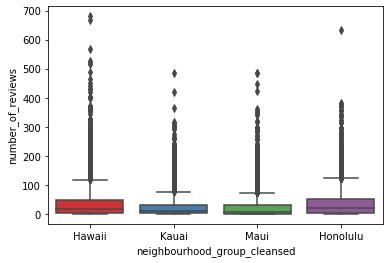

In [82]:
# Hypothesis candidates: 
# Neighborhood
#     - Is rating related to price within a neighborhood? 
#     - The highest price properties in a neighboorhood will have lower ratings than the lowest price properties?
#      - Best neighborhoods by rating
#      - Best neighborhoods by price
#      - Listing types by neighborhood
#      - Listing types by price
#      - Listing types by rating
# By island: 
#      - Is one island more expensive than the others?

import seaborn as sns
#sns.boxplot(x="day", y="total_bill", hue="smoker", data=df, palette="Set1")
sns.boxplot(
    x = "neighbourhood_group_cleansed",
    y = "number_of_reviews",
    #hue = "price",
    data = df,
    palette = "Set1"
)

# Bin by island
# data_dict[(data_dict["Group"] == "Property-related") & (data_dict["Subgroup"] == "Pricing")]

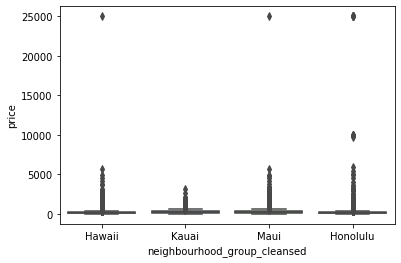

In [83]:
# Hypothesis candidates: 
# Neighborhood
#     - Is rating related to price within a neighborhood? 
#     - The highest price properties in a neighboorhood will have lower ratings than the lowest price properties?
#      - Best neighborhoods by rating
#      - Best neighborhoods by price
#      - Listing types by neighborhood
#      - Listing types by price
#      - Listing types by rating
# By island: 
#      - Is one island more expensive than the others?

import seaborn as sns
#sns.boxplot(x="day", y="total_bill", hue="smoker", data=df, palette="Set1")
sns.boxplot(
    x = "neighbourhood_group_cleansed",
    y = "price",
    data = df,
    palette = "Set1"
)

# Bin by island
# data_dict[(data_dict["Group"] == "Property-related") & (data_dict["Subgroup"] == "Pricing")]

In [84]:
data_dict[(data_dict["Group"] == "Property-related") & (data_dict["Subgroup"] == "Pricing")]

,ColumNumber,Column,Group,Subgroup,Notes
5,5,experiences_offered,Property-related,Pricing,
41,41,accommodates,Property-related,Pricing,
47,47,price,Property-related,Pricing,
48,48,weekly_price,Property-related,Pricing,
49,49,monthly_price,Property-related,Pricing,
50,50,security_deposit,Property-related,Pricing,
51,51,cleaning_fee,Property-related,Pricing,
52,52,guests_included,Property-related,Pricing,
53,53,extra_people,Property-related,Pricing,


In [ ]:
# If a host has a hugh number of properties then their ratings are not higher 
#     than hosts with fewer properties
bins = [1, 60, 119, 179, 239, 299]

# labels - always one less than the range
group_names = ["0-59 properties", "60-119 properties", "120-179 properties", "180-239 properties", "240+ properties"]

df["Bin_NumProperties"] = pd.cut(df["host_total_listings_count"], bins, labels=group_names)

# df_analyze = pd.concat([df["host_id"], df["host_total_listings_count"], df["Bin_NumProperties"]]).unique()
df_analyze = df.groupby(["host_id", "host_total_listings_count"])
df_analyze.head()

df.groupby(["host_id", "host_total_listings_count"]).count()
# Hosts that have host_total_listings_count == 0

any_dupe_listings = df.groupby(["host_id"]).agg({
        # number of unique listings
        'host_total_listings_count': "nunique"
    }
)

# Are there any where the listing count is wrong?
#print(len(any_dupe_listings[any_dupe_listings["host_total_listings_count"]]
#any_dupe_listings.filter(lambda x: len(x) > 1)  
any_dupe_listings[any_dupe_listings["host_total_listings_count"] > 1]
print("No - no bad data")

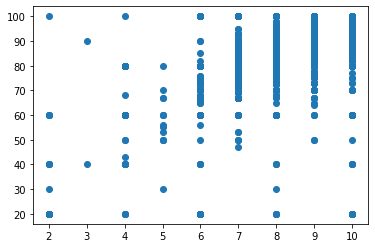

In [88]:
# Drop all values outside the normal distribution:
x_values = df["review_scores_cleanliness"]
y_values = df["review_scores_rating"]
plt.scatter(x_values, y_values)

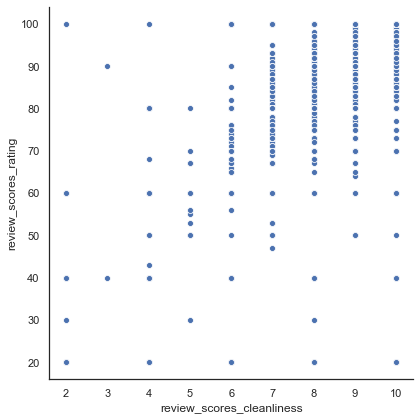

In [97]:
sns.set(style="white")

x_values = df["review_scores_cleanliness"]
y_values = df["review_scores_rating"]

sns.relplot(
    x="review_scores_cleanliness", 
    y="review_scores_rating", 
    #hue="origin", 
    #size="weight",
    #sizes=(40, 400), 
    #alpha=.5, 
    palette="muted",
    height=6, 
    data=df
)

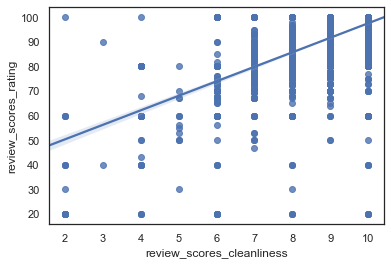

In [99]:
sns.regplot(
    x="review_scores_cleanliness", 
    y="review_scores_rating", 
    data=df
);

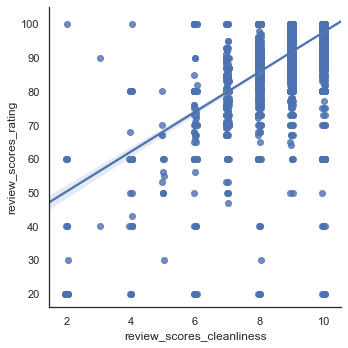

In [105]:
sns.lmplot(
    x="review_scores_cleanliness", 
    y="review_scores_rating", 
    data=df,
    x_jitter=.05
);

In [ ]:
sns.lmplot(
    x="review_scores_cleanliness", 
    y="review_scores_rating", 
    data=df,
    x_jitter=.05,
    x_estimator=np.mean,
    hue="reviews_per_month"
);

In [107]:
df.head()

,id,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,...,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,Bin_NumReviews,Bin_NumProperties
0,5065,MAUKA BB,"Perfect for your vacation, Staycation or just ...",Mauka B & B is 400 square feet studio with a p...,"Perfect for your vacation, Staycation or just ...",none,Neighbors here are friendly but are not really...,Located near by is Kalopa State Park with 100 ...,There is a bus stop located in Honoka'a town ...,A BBQ grill is available,...,moderate,f,f,2,2,0,0,0.45,11-20,0-59 properties
1,5269,Upcountry Hospitality in the 'Auwai Suite,"The 'Auwai Suite is a lovely, self-contained a...","The ‘Auwai Suite is a lovely, self-contained a...","The 'Auwai Suite is a lovely, self-contained a...",none,"We are located on the ""sunny side"" of Waimea, ...",NaN,One parking spot is provided with your stay.,You'll have access to your private garden suit...,...,strict_14_with_grace_period,f,f,5,4,1,0,0.09,NaN,0-59 properties
2,5387,Hale Koa Studio & 1 Bedroom Units!!,This Wonderful Spacious Studio apt/flat is in ...,"Hale Koa Duplex: This duplex has a wonderful, ...",This Wonderful Spacious Studio apt/flat is in ...,none,IN a Farm belt area with small commercial farm...,tropical setting with view and easy access to ...,"Close to Major highway (belt road) accessable,...","entire apartment, with full kitchen, baths an...",...,strict_14_with_grace_period,f,f,3,3,0,0,1.36,100-200,0-59 properties
3,5389,Keauhou Villa,It is less than 10 minute walk to the Keauhou ...,"Location: Keauhou, Kona Coast, Big Island, Haw...",It is less than 10 minute walk to the Keauhou ...,none,It is less than 10 minute walk to the Keauhou ...,It is less than 10 minute walk to the Keauhou ...,It is less than 10 minute walk to the Keauhou ...,"Entire House with Garage, Screened Lanai, Fron...",...,flexible,f,f,3,3,0,0,0.23,1-10,0-59 properties
4,5390,STAY AT PRINCE KUHIO!,NaN,"Prince Kuhio, Studio Unit. Sleeps 2 privately....","Prince Kuhio, Studio Unit. Sleeps 2 privately....",none,NaN,NaN,NaN,NaN,...,strict_14_with_grace_period,f,f,1,1,0,0,1.01,100-200,0-59 properties


In [ ]:
# QUestion: Of the six dimensions for ratings (Accuracy, Cleanliness, Checkin, Communication, Location, Value), 
# is one more important than the rest? 
# Example: if a property is a low Cleanliness score, would it be more likely that all other scores 
# are also lower on average?

# Linear regression
from sklearn.linear_model import LinearRegression

# https://towardsdatascience.com/linear-regression-in-6-lines-of-python-5e1d0cd05b8d
#X = df.iloc[:, 0].values.reshape(-1, 1)  # values converts it into a numpy array
#Y = df.iloc[:, 1].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column

x = df["review_scores_rating"]
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions


review_scores_rating
review_scores_accuracy
review_scores_cleanliness
review_scores_checkin
review_scores_communication
review_scores_location
review_scores_value


x_values = housing_data['RM']
y_values = housing_data['MEDV']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(6,10),fontsize=15,color="red")
plt.xlabel('Rooms in House')
plt.ylabel('Median House Prices ($1000)')
plt.show()